# Histograms for three regions: all time steps

This notebook is itended to show a general shape of the distribution of the Mixed Layer Depth in three different regions using the ARMOR-3D and ISAS datasets. Both datasets are different in spatial and temporal resolution. 

ARMOR-3D contains 3D arrays for salinity, temperature, geostrophic velocity and geopotential height; and one in 2D for the Mixed Layer Depth. The spatial resolution is of $ 0.25^o $, in both longitude and latitude, and with a weekly sampling. Furthermore, ARMOR-3D contains data from 2005 to 2018, making a total of 730 weekly time steps for each one of the variables. This dataset also has a vertical axis that goes from 0 to 5000 meters, spread in 33 levels.


In the other hand, ISAS is a 2D dataset of MLD, temperature and salinity. It uses a montly frequency and a spatial resolution of $ 0.5^o $. This data set consists in data from 2006 to 2015, making a total of 120 monthly values for each variable. This dataset does not have z coordinate!!

The regions chosen were:

    1. North Eastern Atlantic
    2. Gulf Stream
    3. Labrador and Irminger seas
    
    
In the following subsections will be described the code used and the size of the regions used.

### Imported libraries

In [1]:
#########################
#########  
######### 
#########################

import cartopy

import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

import datetime
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Dictionary used

This dictionary contains the points corresponding to the perimeter of the regions to use. It consists in a dictionary named 'reg_ext' whose key words are the short versions of the name of the regions. The value for each key is other dictionary, that contains the information of the longitude and latitude as tuples and the name in string for the region. 

In [2]:
#########################
######### DICTIONARIES DEFINITION 
#########################

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

### Function definitions

In this notebook 4 different functions were used. Their names are: *Grid*, *Crops*, *Histogram* and *No_nan*. The description of each one is in the function's description.

In [8]:
def Grid(data_set):
    """
        Grid is a function that creates a rectangular grid using as x a longitude
        array and for y a latitude array.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        Output:
        -------
        (x, y) : n-arrays
            Arrays that correspond for each (lon,lat) point
    """
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


## Function to crop the dataset

def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))

    return(new_ds)


def Histogram(data_set, n_bins, xlims=None, ylims=None, i=None, ax=None):
    """
        Histogram is a function that helps to make a semi-log histogram plot
        of a dataset. The 'y' axis is logaritmic, and the 'x' axis is linear.
        The function accepts a dataset with any kind of values and it filters the
        nan values.
        
        Parameters:
        ------------
            
        data_set : DataArray
            Is the dataset from which we will plot the histogram.
        
        n_bins : integer
            Number of bins for the histogram.
            
        xlims : tuple, float
            The limits for the x axis
        
        ylims : tuple, float
            The limits for the y axis
        
        i : integer
            Is the time step we adre working on. if None, it returns the
            complete array's histogram
            
        ax : axes.Axes object or array of Axes objects
            axes of the n-th sub plot
        
        Output:
        -------
        Plot, Fig.
    """
    ## Creation of an array to save all values for the histogram
    ### This could be done in a faster way!!
    
    a = []
    
    if i == None:
        for j in range(len(data_set[:])):
            a = np.append(a, data_set[j])
    else:
        for j in range(len(data_set[i])):
            a = np.append(a, data_set[i, j])

    ##Taking away the nan values
    a2 = No_nan(a)
    ran = (xlims)
        
    if not ax:
        ax = plt.gca()
    
    ax.hist(a2, n_bins, range=ran, alpha=0.75)
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.grid(True)
    
    
def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)

In [18]:
## Opening the datasets    
### it is pending to change the directory for ARMOR!!

dir_1 = '/home/lgarcia/Documents/data_ARMOR/'
dir_2 = '/net/alpha/exports/sciences/data/LPO_ISAS/ANA_ISAS15/fld2D/'

fl_n1 = 'ARMOR_*.nc'
fl_n2 = 'ISAS15_DM_2006_2015_MLDS.nc'


## mld_a and mld_i are the data arrays that have MLD(t, lon, lat) 
## values only. For armor and isas, respectively.
c_armor = xr.open_mfdataset(dir_1 + fl_n1)
mld_a = c_armor.mlotst

# Calculating monthly averages for ARMOR
monthly_avg = mld_a.resample(time="1MS").mean('time')

c_isas = xr.open_mfdataset(dir_2 + fl_n2)
mld_i = c_isas.MLDP


## Checking the shape of ISAS
#c_isas

## Checking shape for monthly_average

reg_noeM = Crops(coord, monthly_avg)
reg_noeM

<xarray.DataArray 'mlotst' (time: 168, latitude: 60, longitude: 100)>
dask.array<shape=(168, 60, 100), dtype=float32, chunksize=(1, 60, 100)>
Coordinates:
  * time       (time) datetime64[ns] 2005-01-01 2005-02-01 ... 2018-12-01
  * latitude   (latitude) float32 45.125 45.375 45.625 ... 59.375 59.625 59.875
  * longitude  (longitude) float32 -29.875 -29.625 -29.375 ... -5.375 -5.125

## 1. North Eastern Atlantic

This region spans in longitude (30W, 5W), latitude (45N, 60N). This means, is a region of 25x15 degrees. This region, is thus, represented by:

 ### 1.1.  ARMOR:  an array of about 100x60 surface grid points. 
   This means that for each time step (weekly data), the region will be represented by an estimate of 6000 grid points. Roughly speaking, then, for this region we will find 4.38e6 grid points for all the years.
    
 ### 1.2. ISAS: an array of about 50x30 grid points. 
   Being this represented by a approximate of 1500 grid points, in each time step. Therefore the complete dataset for one variable in the horizontal will contain an approximate value of 1.8e5 grid points.

<IPython.core.display.Javascript object>


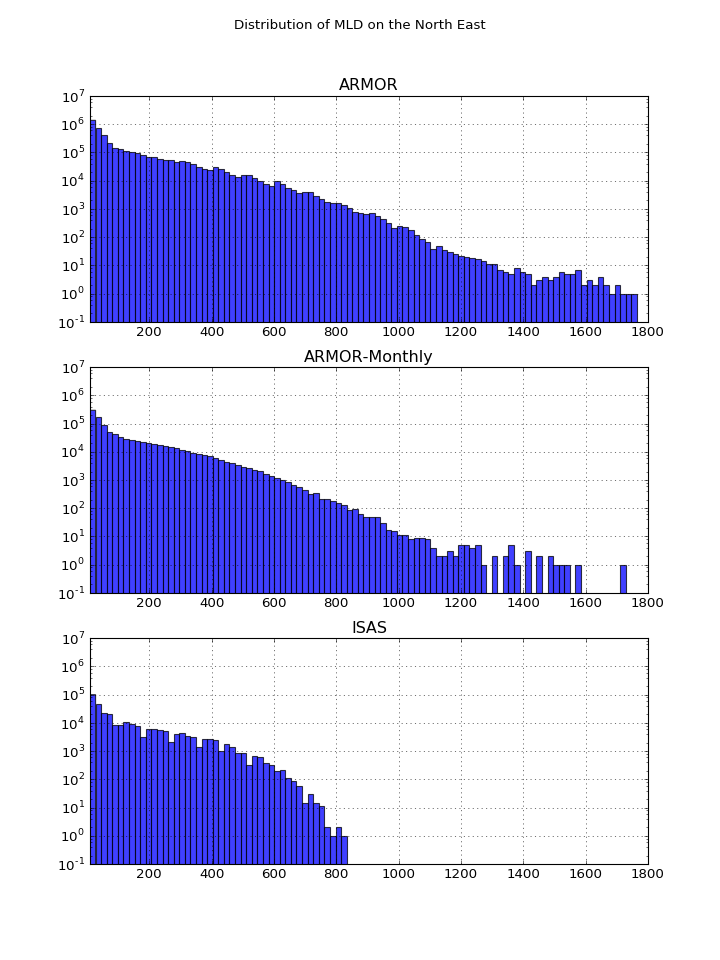

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [20]:
###### Preparing the plot for the North East Region
## This histogram is for all data contained in the 
## in the complete region of Northe East in mld_a and mld_i. 
## For this region armor contains 100*60*730 = 4.380e6 grid points
##         armor-average contains 100*60*168 = 1.008e6 grid points
##    and for isas it is contains 120*50*51 = 3.06e5 grid points

coord = 'noe'
reg_noeA = Crops(coord, mld_a)
reg_noeM = Crops(coord, monthly_avg)
reg_noeI = Crops(coord, mld_i)
xlims = 10, 1800
ylims = 10e-2, 10e6
t = ':'

%matplotlib notebook

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(9,12), sharey=True)
Histogram(reg_noeA, 100, xlims, ylims, None, ax[0])
ax[0].set_title('ARMOR')

Histogram(reg_noeM, 100, xlims, ylims, None, ax[1])
ax[1].set_title('ARMOR-Monthly')

Histogram(reg_noeI, 100, xlims, ylims, None, ax[2])
ax[2].set_title('ISAS')

fig.suptitle('Distribution of MLD on the North East')
#plt.savefig('/home/lgarcia/Documents/Scripts/Images/Noe-PDF.png')
plt.show()

## 2. Labrador and Irminger seas

This region spans in longitude (60W, 30W), latitude (50N, 65N), occuping 30x15 degrees. 

 ### 2.1.  ARMOR:  an array of about 120 x 60 surface grid points. 
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.
    
 ### 2.2. ISAS: an array of about 60 x 30 grid points. 
   Being this represented by a approximate of 1800 grid points, in each time step. Therefore the complete dataset for one variable in the horizontal will contain an approximate value of 2.16e5 grid points.


<IPython.core.display.Javascript object>


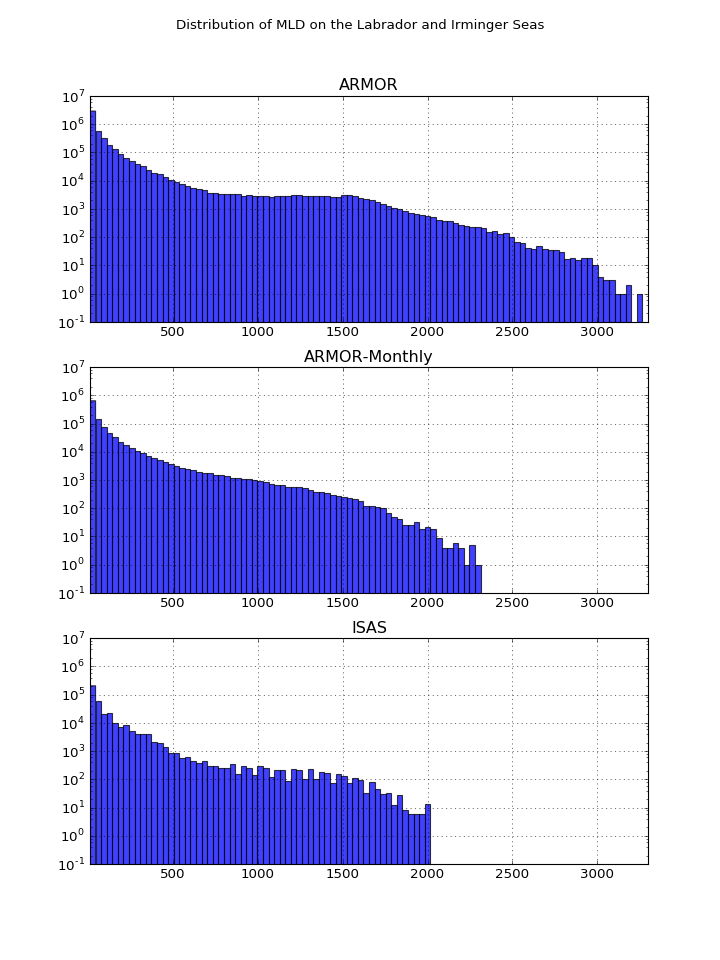

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [21]:
###### Preparing the plot for the Labrador and Irminger Seas
## This histogram is for all data contained in the 
## in the complete region of Labrador/Irminger in mld_a and mld_i. 
## For this region armor contains 730*60*120 = 5.256e6  grid points
##         armor-average contains 168*60*120 = 1.2096e6 grid points
##  and for isas it is   contains 120*57*61  = 4.1724e5 grid points

coord = 'lab'
reg_labA = Crops(coord, mld_a)
reg_labM = Crops(coord, monthly_avg)
reg_labI = Crops(coord, mld_i)
xlims = 10, 3300
ylims = 10e-2, 10e6


%matplotlib notebook

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(9,12), sharey=True)
Histogram(reg_labA, 100, xlims, ylims, None, ax[0])
ax[0].set_title('ARMOR')

Histogram(reg_labM, 100, xlims, ylims, None, ax[1])
ax[1].set_title('ARMOR-Monthly')

Histogram(reg_labI, 100, xlims, ylims, None, ax[2])
ax[2].set_title('ISAS')

fig.suptitle('Distribution of MLD on the Labrador and Irminger Seas')
#plt.savefig('/home/lgarcia/Documents/Scripts/Images/Lab-PDF.png')
plt.show()

## 3. Gulf Stream

This region spans in llongitude (75W, 45W), latitude (30N, 45N), being a region of 30x15 degrees.

  ### 3.1.  ARMOR:  an array of about 120 x 60 surface grid points. 
   This means that for each time step (weekly data), the region will be represented by an estimate of 7200 grid points. Roughly speaking, then, for this region we will find 5.256e6 grid points for all the years.
    
 ### 3.2. ISAS: an array of about 60 x 30 grid points. 
   Being this represented by a approximate of 1800 grid points, in each time step. Therefore the complete dataset for one variable in the horizontal will contain an approximate value of 2.16e5 grid points.

<IPython.core.display.Javascript object>


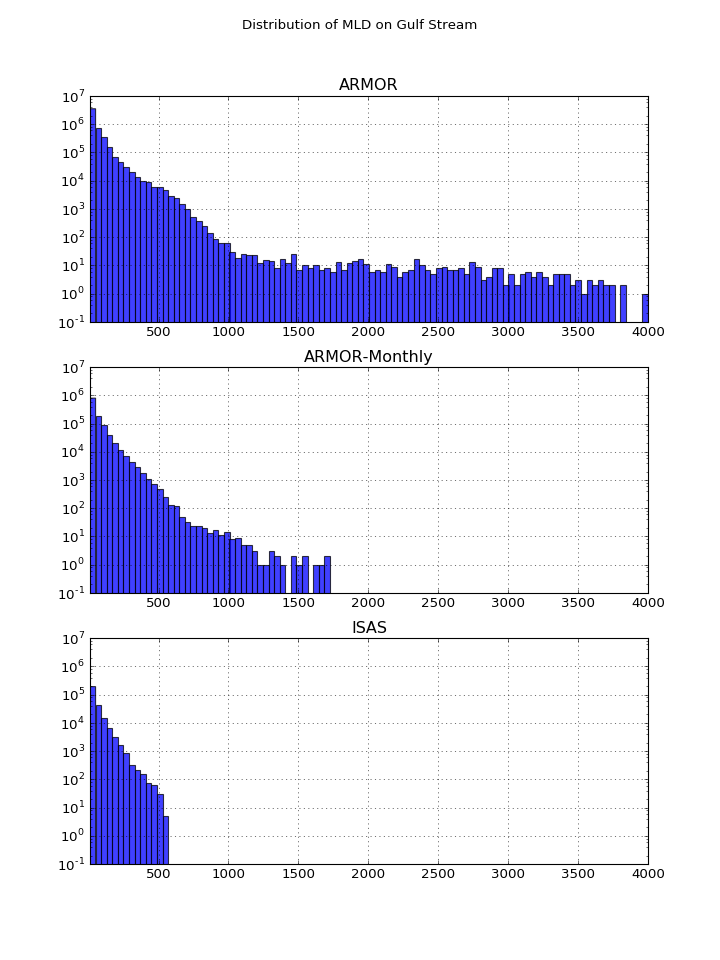

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [27]:
###### Preparing the plot for the Gulf Stream
## This histogram is for all data contained in the 
## in the complete region of Gulf Stream in mld_a and mld_i. 
## For this region armor contains 730*60*120 = 5.256e6 grid points
##         armor-average contains 168*60*120 = 1.2096e6 grid points
##    and for isas it is contains 120*38*61 = 2.7816e5 grid points

coord = 'gul'
reg_gulA = Crops(coord, mld_a)
reg_gulM = Crops(coord, monthly_avg)
reg_gulI = Crops(coord, mld_i)
xlims = 10, 4000
ylims = 10e-2, 10e6

%matplotlib notebook

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(9,12), sharey=True)
Histogram(reg_gulA, 100, xlims, ylims, None, ax[0])
ax[0].set_title('ARMOR')

Histogram(reg_gulM, 100, xlims, ylims, None, ax[1])
ax[1].set_title('ARMOR-Monthly')

Histogram(reg_gulI, 100, xlims, ylims, None, ax[2])
ax[2].set_title('ISAS')

fig.suptitle('Distribution of MLD on Gulf Stream')
#plt.savefig('/home/lgarcia/Documents/Scripts/Images/Gul-PDF.png')
plt.show()

## 4. Some observations

## Code for animations


This code is used to plot each of the time steps for the animation. It considers a embeded plot that makes a zoom during the summer months.

In [ ]:
### Function to create all the figures to make the animation 
### histogram/time. It plots a small zoomed area in the histogram
### for the summer/autum time, i.e. June-November, that allows 
### to see more details of the distribution if the grid points.


import os
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.use('Agg')

N = int(mld_a.time.size)

print(N)

def generate_one_figure(it=1):
    print(it)

    dir_1 = '/home/lgarcia/Documents/data_ARMOR/'
    fl_n1 = 'ARMOR_*.nc'
    c_armor = xr.open_mfdataset(dir_1 + fl_n1)
    mld_a = c_armor.mlotst
    
    list_month = [6, 7, 8, 9, 10, 11]
    
    time = pandas.to_datetime(mld_a[it].time.values)
    month = time.month
    
    coord = 'noe'
    reg = Crops(coord, mld_a)
    
    n_bins = 100
    xlim = 10., 1800.
    ylim = 10e-1, 10e4

    Histogram(reg, n_bins, xlim, ylim, it)
    plt.xlabel('MLD (m)')
    plt.ylabel('# of occuped grid points')
    plt.title(time)
    plt.hlines(120*60, *xlim)

    if month in list_month:
        xlim2 = 9., 250.
        ylim2 = 10e-1, 10e4

        # this is an inset axes over the main axes
        a = plt.axes([.45, .65, .42, .2])
        Histogram(reg, n_bins, xlim2, ylim2, it)
        plt.xticks()
        plt.yticks()
    
    
    plt.savefig(os.path.abspath(os.path.sep.join(["/home/lgarcia/Documents/Scripts/dummy_images","N-PDF_%0.4d.png" % it])))
    plt.close()
    return None



print('Use %i processes' % multiprocessing.cpu_count() ) 

with multiprocessing.Pool() as pool:
    pool.map( generate_one_figure, np.arange(0, N) )  
    
print('finish!')  

## mencoder "mf://dummy_images/Gul_*.png" -mf fps=10 -o Gulf.avi -ovc lavc -lavcopts 
## vcodec=msmpeg4v2:vbitrate=2500

## ffmpeg -r 1.5 -f image2 -s 1920x1080 -i dummy_images/N-PDF_%04d.png -vcodec libx264 
## -crf 25  -pix_fmt yuv420p -q:v 1 N2-PDF.mp4